In [1]:
import numpy as np
import scipy as sp
import matplotlib
matplotlib.use('pgf')
import matplotlib.pyplot as plt
%matplotlib inline
import astropy
import astropy.constants as c
import astropy.units as u
from astropy.io import ascii
from scipy.stats import binned_statistic
from scipy import interpolate
from zigm import zigm

In [2]:
#plt.rcParams['text.usetex'] = True
plt.rcParams['pgf.rcfonts'] = False
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')

In [3]:
no_DLA_src_file = ascii.read('noDLA_meiksin_7_1_src.dat')
no_wav = np.array(no_DLA_src_file[0][:])
no_src = np.array(no_DLA_src_file[1][:])
no_DLA_src = np.vstack((no_wav,no_src))

DLA_23_1_src_file = ascii.read('DLA_23_1_src.dat')
DLA_wav = np.array(DLA_23_1_src_file[0][:])
DLA_src = np.array(DLA_23_1_src_file[1][:])
DLA_23_1_src = np.vstack((DLA_wav,DLA_src))


[0.04944414 0.0492816  0.04911941 ... 0.9162087  0.91608626 0.9159656 ]
[[9.6453178e+02 9.6464038e+02 9.6474898e+02 ... 1.1313413e+03
  1.1314499e+03 1.1315585e+03]
 [1.9939141e-01 1.9873821e-01 1.9591706e-01 ... 3.9906135e-01
  4.1203206e-01 4.4558065e-01]]


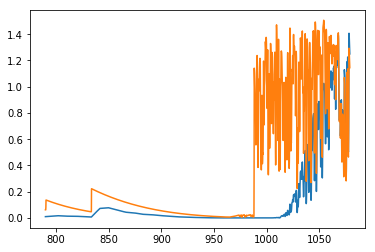

In [6]:
SNR_file = ascii.read('A1689_16hours_signal_to_noise_XTcalc.dat')
SNR_wav = np.array(SNR_file[0][:])*1000
SNR_snr = np.array(SNR_file[1][:])
SNR_src = np.vstack((SNR_wav,SNR_snr))
f = interpolate.interp1d(SNR_src[0,:],SNR_src[1,:],fill_value='extrapolate')
no_DLA_SNR = np.vstack((no_DLA_src[0,:],f(no_DLA_src[0,:])*no_DLA_src[1,:]/max(no_DLA_src[1,:])))
DLA_23_1_SNR = np.vstack((DLA_23_1_src[0,:],f(DLA_23_1_src[0,:])*DLA_23_1_src[1,:]/max(DLA_23_1_src[1,:])))
plt.plot(DLA_23_1_SNR[0,:],DLA_23_1_SNR[1,:])
plt.plot(no_DLA_SNR[0,:],no_DLA_SNR[1,:])
print((no_DLA_src[1,:])/max(no_DLA_src[1,:]))
print(SNR_src)

In [ ]:
# no_DLA_SNR_file = ascii.read('noDLA_meiksin_7_1_20hr.dat')
# no_wav = np.array(no_DLA_SNR_file[0][:])
# no_SNR = np.array(no_DLA_SNR_file[1][:])
# no_DLA_SNR = np.vstack((no_wav,no_SNR))

# DLA_23_1_SNR_file = ascii.read('DLA_23_1_20hr.dat')
# DLA_wav = np.array(DLA_23_1_SNR_file[0][:])
# DLA_SNR = np.array(DLA_23_1_SNR_file[1][:])
# DLA_23_1_SNR = np.vstack((DLA_wav,DLA_SNR))


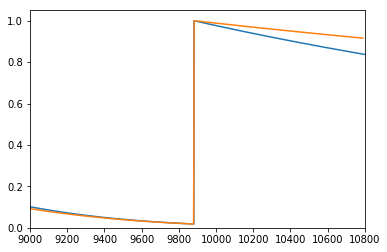

In [7]:
lam = no_wav*10
lam = np.linspace(7000,15000,10000)
z = 7.132
z1 = 1 + z
S = lam**-2.0
tau = zigm(lam,z,method="Meiksin")
F = S*np.exp(-tau)
plt.axis([9000,10800,0.0,1.05])
plt.plot(lam,F/F.max(),no_wav*10,no_src/no_src.max())
ascii.write([lam/10,F/F.max()],output='meiksin_7_1.dat',names=('wav','flux'),format='no_header',overwrite=True)

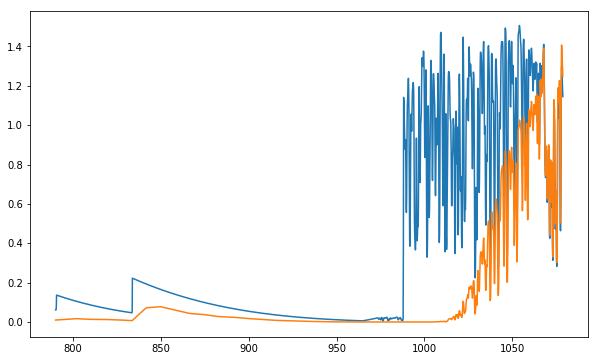

In [8]:

plt.figure(figsize=(10,6))
plt.plot(no_DLA_SNR[0,:],no_DLA_SNR[1,:],DLA_23_1_SNR[0,:],DLA_23_1_SNR[1,:])

In [9]:
eps_noise = 1e-8
tmp = 100

bins = 50

DLA_23_1_SNR_tmp = np.copy(DLA_23_1_SNR)
js = np.where(DLA_23_1_SNR_tmp[1,:]<=0.0)
DLA_23_1_SNR_tmp[1,js] = tmp

no_DLA_sim = np.random.normal(no_DLA_src[1,:],
                              no_DLA_src[1,:]/no_DLA_SNR[1,:],
                              no_DLA_src[1,:].shape)
DLA_23_1_sim = np.random.normal(DLA_23_1_src[1,:],
                                DLA_23_1_src[1,:]/DLA_23_1_SNR_tmp[1,:],
                                DLA_23_1_src[1,:].shape)

no_DLA_sim_err = no_DLA_src[1,:]/no_DLA_SNR[1,:]
DLA_23_1_sim_err = DLA_23_1_src[1,:]/DLA_23_1_SNR_tmp[1,:]

DLA_23_1_sim[js] = np.random.normal(DLA_23_1_src[1,js],eps_noise,DLA_23_1_src[1,js].shape)
DLA_23_1_sim_err[js] = eps_noise
no_DLA_binned = binned_statistic(no_DLA_src[0,:], no_DLA_sim, bins=bins)
DLA_23_1_binned = binned_statistic(DLA_23_1_src[0,:], DLA_23_1_sim, bins=bins)

def sqrtsum(x):
    return np.sqrt((x**2).sum())/x.size

no_DLA_binned_err = binned_statistic(no_DLA_SNR[0,:], no_DLA_sim_err, statistic=sqrtsum, bins=bins)[0]
DLA_23_1_binned_err = binned_statistic(DLA_23_1_SNR[0,:], DLA_23_1_sim_err, statistic=sqrtsum, bins=bins)[0]



/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


<ErrorbarContainer object of 3 artists>

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


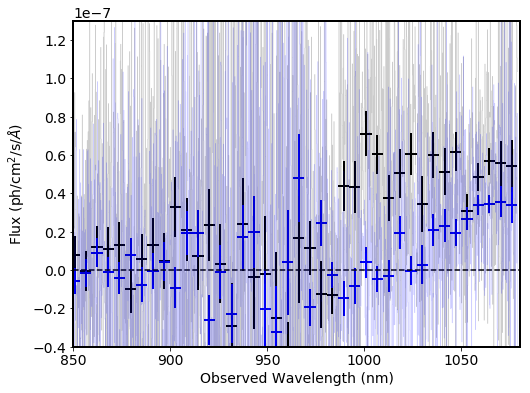

In [10]:
no_DLA_bincentres = no_DLA_binned[1][:-1] + np.diff(no_DLA_binned[1])/2
DLA_23_1_bincentres = DLA_23_1_binned[1][:-1] + np.diff(DLA_23_1_binned[1])/2

plt.rcParams['axes.linewidth'] = 2.0 #set the value globally
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)


plt.figure(figsize=(8,6))
plt.axis((850,1080,-4e-8,13.0e-8))
plt.xlabel("Observed Wavelength (nm)")
plt.ylabel("Flux (ph/cm$^2$/s/$\AA$)")
plt.plot([850,1100],[0,0],'k--')
plt.plot(no_DLA_src[0,:],no_DLA_sim,'k-',drawstyle="steps-mid",lw=0.5,alpha=0.2)
plt.plot(DLA_23_1_src[0,:],DLA_23_1_sim,'b-',drawstyle="steps-mid",lw=0.5,alpha=0.2)
plt.errorbar(no_DLA_bincentres,no_DLA_binned[0],
             xerr=np.diff(no_DLA_binned[1])/2,
             yerr=no_DLA_binned_err,
             uplims=False,
             drawstyle="steps-mid", ls="",lw=2,marker="",color="k",capsize=0)
plt.errorbar(DLA_23_1_bincentres,DLA_23_1_binned[0],
             xerr=np.diff(DLA_23_1_binned[1])/2,
             yerr=DLA_23_1_binned_err,
             uplims=False,
             drawstyle="steps-mid", ls="",lw=2,marker="",markersize=5,color="b",capsize=0)

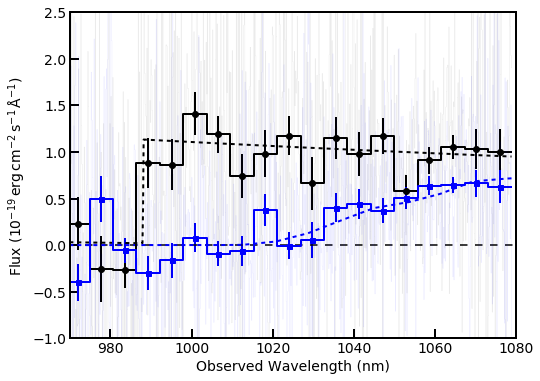

In [15]:
no_DLA_erg_ph = (no_DLA_src[0,:]*u.nm).to(u.erg,equivalencies=u.spectral()).value
DLA_23_1_erg_ph = (DLA_23_1_src[0,:]*u.nm).to(u.erg,equivalencies=u.spectral()).value
no_DLA_bin_erg_ph = (no_DLA_bincentres*u.nm).to(u.erg,equivalencies=u.spectral()).value
DLA_23_1_bin_erg_ph = (DLA_23_1_bincentres*u.nm).to(u.erg,equivalencies=u.spectral()).value
plt.figure(figsize=(8,6))
plt.axis((970,1080,-1.0,2.5))
plt.tick_params(axis='both',direction='in', length=9, width=2, colors='k')
plt.xlabel("Observed Wavelength (nm)")
#plt.ylabel("O")
#plt.ylabel("Flux ($10^{-19}\,{\\rm erg\,cm}^{-2}\,{\\rm s}^{-1}\,{\\rm \AA}^{-1}$)")
plt.ylabel("Flux ($10^{-19}\,$erg$\,$cm$^{-2}\,$s$^{-1}\,\mathrm{\AA}^{-1}$)")
plt.plot([970,1080],[0,0],'k--',dashes=(5, 5))
plt.plot(no_DLA_src[0,:],1e19*no_DLA_erg_ph*no_DLA_sim,'k-',drawstyle="steps-mid",lw=0.4,alpha=0.1)
plt.plot(DLA_23_1_src[0,:],1e19*DLA_23_1_erg_ph*DLA_23_1_sim,'b-',drawstyle="steps-mid",lw=0.4,alpha=0.1)
plt.errorbar(no_DLA_bincentres,1e19*no_DLA_bin_erg_ph*no_DLA_binned[0],
             xerr=np.diff(no_DLA_binned[1])/2,
             yerr=1e19*no_DLA_bin_erg_ph*no_DLA_binned_err,
             uplims=False,
             drawstyle="steps-mid", ls="-",lw=2,marker="o",color="k",capsize=0)
plt.errorbar(DLA_23_1_bincentres,1e19*DLA_23_1_bin_erg_ph*DLA_23_1_binned[0],
             xerr=np.diff(DLA_23_1_binned[1])/2,
             yerr=1e19*DLA_23_1_bin_erg_ph*DLA_23_1_binned_err,
             uplims=False,
             drawstyle="steps-mid", ls="-",lw=2,marker="s",markersize=5,color="b",capsize=0)
plt.plot(no_DLA_src[0,:],1e19*no_DLA_erg_ph*no_DLA_src[1,:],'k--',dashes=(2, 2),drawstyle="default",lw=2.0,alpha=1.0)
plt.plot(DLA_23_1_src[0,:],1e19*no_DLA_erg_ph*DLA_23_1_src[1,:],'b--',dashes=(2, 2),drawstyle="default",lw=2.0,alpha=1.0)
plt.savefig('MOSFIRE_simulation_16hr.pdf', bbox_inches='tight')
plt.savefig('MOSFIRE_simulation_16hr.pgf')

In [12]:
import aplpy as ap

ImportError: No module named aplpy

In [ ]:
alma = ap.FITSFigure('a1689zd1_cube_freq_b05_ms_line_image.fits')
#alma.tick_labels.set_xformat('dd.dddd')
#alma.tick_labels.set_yformat('dd.dddd')
alma.recenter(197.87474,-01.32188,width=0.0010, height=0.0008)
alma.add_beam()
alma.beam.show()
alma.beam.set_hatch('/')
alma.beam.set_frame(False)
alma.beam.set_color('black')
alma.beam.set_alpha(0.2)
alma.beam.set_edgecolor('black')
alma.beam.set_facecolor('black')
alma.add_grid()
alma.grid.set_alpha(0.05)
alma.grid.set_color('black')
alma.show_colorscale(cmap='pink_r', vmin=0.2e-2, vmax=3.0e-2)
alma.save('alma_line_image.jpg')
hst_clevels = [0.002,0.005,0.008,0.011,0.015]
alma.show_contour('../../../A1689-zD1_CII/A1689_F140W_drz.fits', colors='white', levels=hst_clevels)
alma.save('alma_line_image_w_HST.jpg')